# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection

## Notebook: LightGBM Tuning

***

**What is the objective of this file?**

To tune the model using the Train Split (Dynamically Split).

# Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. LightGBM Tuning Setup

Setting tuning environment parameters.

## 1.0. Tuning Settings

1. What will the output filename of the model be?
2. What is the dictionary of hyperparameter values?

In [1]:
OUTPUT_FILENAME = "RYZEN3b" # <== Specify the filename of the output hyperparameters text file (can be used during tuned model training).

K = 5
DYNAMIC_SPLIT = 1/K # <== Expected validation ratio. Training ratio will be 1-(1/K). Just for when needed to view.
RANDOM_SEED = 1 # <==  <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

**Recommended Parameters as per the paper/documentation:**
1. boosting_type = gbdt
2. class_weight = balanced
3. objective* = binary
4. data_sample_strategy = goss
5. tree_learner = data

*As per documentation relative to study's objectives and needs.

In [2]:
#Sample (tested) parameter set
lgbm_params = {
    #Based-on Study (Do not change)
    'boosting_type':['gbdt'], # <== GBDT Mode
    'class_weight': ['balanced'], # <== Balanced/Weighted equally (i.e., no inherent bias)
    'objective':['binary'], # <== Binary Classification (same as metric:binary_logloss)
    'data_sample_strategy':['goss'], # <== GOSS (solution of LGBM)
    'enable_bundle':['True'],
    
    #Others; Not common but can improve accuracy/performance:
    'tree_learner':['feature'], #For better parallel computing (Reference: https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html)
    'device':['gpu'], # <== Remove 'gpu' if no viable GPU exists in computer; Recommended GPUs: Nvidia GTX 1000 series or higher (CUDA or OpenCL)
    'boost_from_average':['True'], # <== Adjusts initial score to the mean of labels for faster convergence
    
    #GPU Usage Recommendation: https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html#how-to-achieve-good-speedup-on-gpu
    'gpu_use_dp':['False'],
    'max_bin':[255],
    
    #Common (Add and experiment with valid values)
    'learning_rate':[0.1,0.2,0.3], #Default: 0.1
    'cat_l2':[5,7,10], #Default: 10
    'num_leaves':[2,4,8,16,32,64], #Default: 31
    'max_depth':[5,10,50,100,500], #Default: -1
    'n_estimators':[5,10,50,100,500,1000], #Default: 100
    
    #Source: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#tune-parameters-for-the-leaf-wise-best-first-tree
}

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries & Diagnostics

In [3]:
#Python Libraries
import time
from datetime import datetime
import os

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#Metrics (for in-tuning testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
import lightgbm
# import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

start = end = 0
LOG_FILENAME = "LGBM_Tuning_Log.txt"

In [4]:
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{OUTPUT_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)
def print_to_file(label, output):
    global OUTPUT_FILENAME
    filename = f"{OUTPUT_FILENAME}_{label}.tune"
    with open("Outputs/LGBM/" + filename, 'w') as f:
        f.write(str(output))
        f.close()

## 1.2. Loading Datasets

### 1.2.1. Setting Filenames

In [5]:
#Setting filenames of files
TB_Train = "../Dataset/TB/LGBM_TB.csv" # <== Location for Time-based Train Split for LightGBM
#TB_Test = "../Dataset/TB/LGBM_TB_Test.csv" # <== Location for Time-based Test Split for LightGBM
IB_Train = "../Dataset/IB/LGBM_IB.csv" # <== Location for Instance-based Train Split for LightGBM
#IB_Test = "../Dataset/IB/LGBM_IB_Test.csv" # <== Location for Instance-based Test Split for LightGBM

### 1.2.2. Loading datasets to DataFrames

In [6]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (72298, 101)
IB Train Size: (72298, 101)


### 1.2.3. Previewing datasets

In [7]:
#Previewing Time-based Dataset
tb_train.head()

malware  t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  ...  t_90  t_91  \
0        1  112  274  158  215  274  158  215  298   76  ...   117    71   
1        1   82  240  117  240  117  240  117  240  117  ...    40   209   
2        1   82   86   82   37   70   37  240  117  260  ...   198   215   
3        1   82  240  117  240  117  240  117  240  117  ...   141   260   
4        1  286  110  172  240  117  240  117  240  117  ...   260   141   

   t_92  t_93  t_94  t_95  t_96  t_97  t_98  t_99  
0   297   135   171   215    35   208    56    71  
1   260   141   260   141   260   141   260   141  
2   178   215   260    65   260   141    65    20  
3   141   260   141   260   141   260   141   260  
4    65    86    99    71   215   240   117   240  

[5 rows x 101 columns]

In [8]:
#Previewing Instance-based Dataset
ib_train.head()

malware  t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  ...  t_90  t_91  \
0        1  112  274  158  215  298   76  208  172  117  ...   307   307   
1        1   82  240  117  172   16   11  274  158  215  ...   307   307   
2        1   82   86   37   70  240  117  260   40  209  ...   307   307   
3        1   82  240  117  172   16   11  274  158  215  ...   307   307   
4        1  286  110  172  240  117  106  171  260  141  ...   307   307   

   t_92  t_93  t_94  t_95  t_96  t_97  t_98  t_99  
0   307   307   307   307   307   307   307   307  
1   307   307   307   307   307   307   307   307  
2   307   307   307   307   307   307   307   307  
3   307   307   307   307   307   307   307   307  
4   307   307   307   307   307   307   307   307  

[5 rows x 101 columns]

## 1.3. Preparing Stratified K-Folds for RandomizedSearchCV

By default, RandomizedSearchCV uses a normal K-Folds with k value of 5.

### 1.3.1. Underlying Code for Stratified K-Folds

Most of the code is for visualizing actually. Only `getStratKFold()` matters.

In [9]:
def get_strat_kfold():
    global K
    return StratifiedKFold(n_splits=K, shuffle=True, random_state=1)

#K-folds sample visualization
def kfolds_vis(dataset):
    global K
    X = dataset.iloc[:,1:101] #All rows, 2nd to last column
    y = dataset.iloc[:,0] #All rows, first column only
    fig, ax = plt.subplots(figsize=(10,K+1), dpi=300)
    train = plot_cv_indices(get_strat_kfold(), X, y, ax, K)
    plt.show()

#K-folds sample visualization (inner workings)
def plot_cv_indices(cv, X, y, ax, n_splits, lw=25):
    #From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt], indices[tr] = 1,0
        ax.scatter(range(len(indices)), [ii] * len(indices), c=indices, marker="_", 
                   lw=lw, cmap=plt.cm.Paired, vmin=0, vmax=1)
    #ax.scatter(range(len(X)), [ii] * len(X), c=y, marker="_", lw=lw, cmap=plt.cm.Paired)
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits), yticklabels=yticklabels, xlabel="Dataset Subsample", ylabel="CV iteration", ylim=[n_splits,-1], xlim=[0, X.shape[0]])
    ax.set_title("{}".format(type(cv).__name__))
    return ax

### 1.3.2. Visualizing the K-Folds

The objective of the visualization is to show that no CV iteration will have the same set of samples (i.e., no overfitting).

Stratified K-Folds Split at 5 splits.
TB/TB_Encoded Dataset


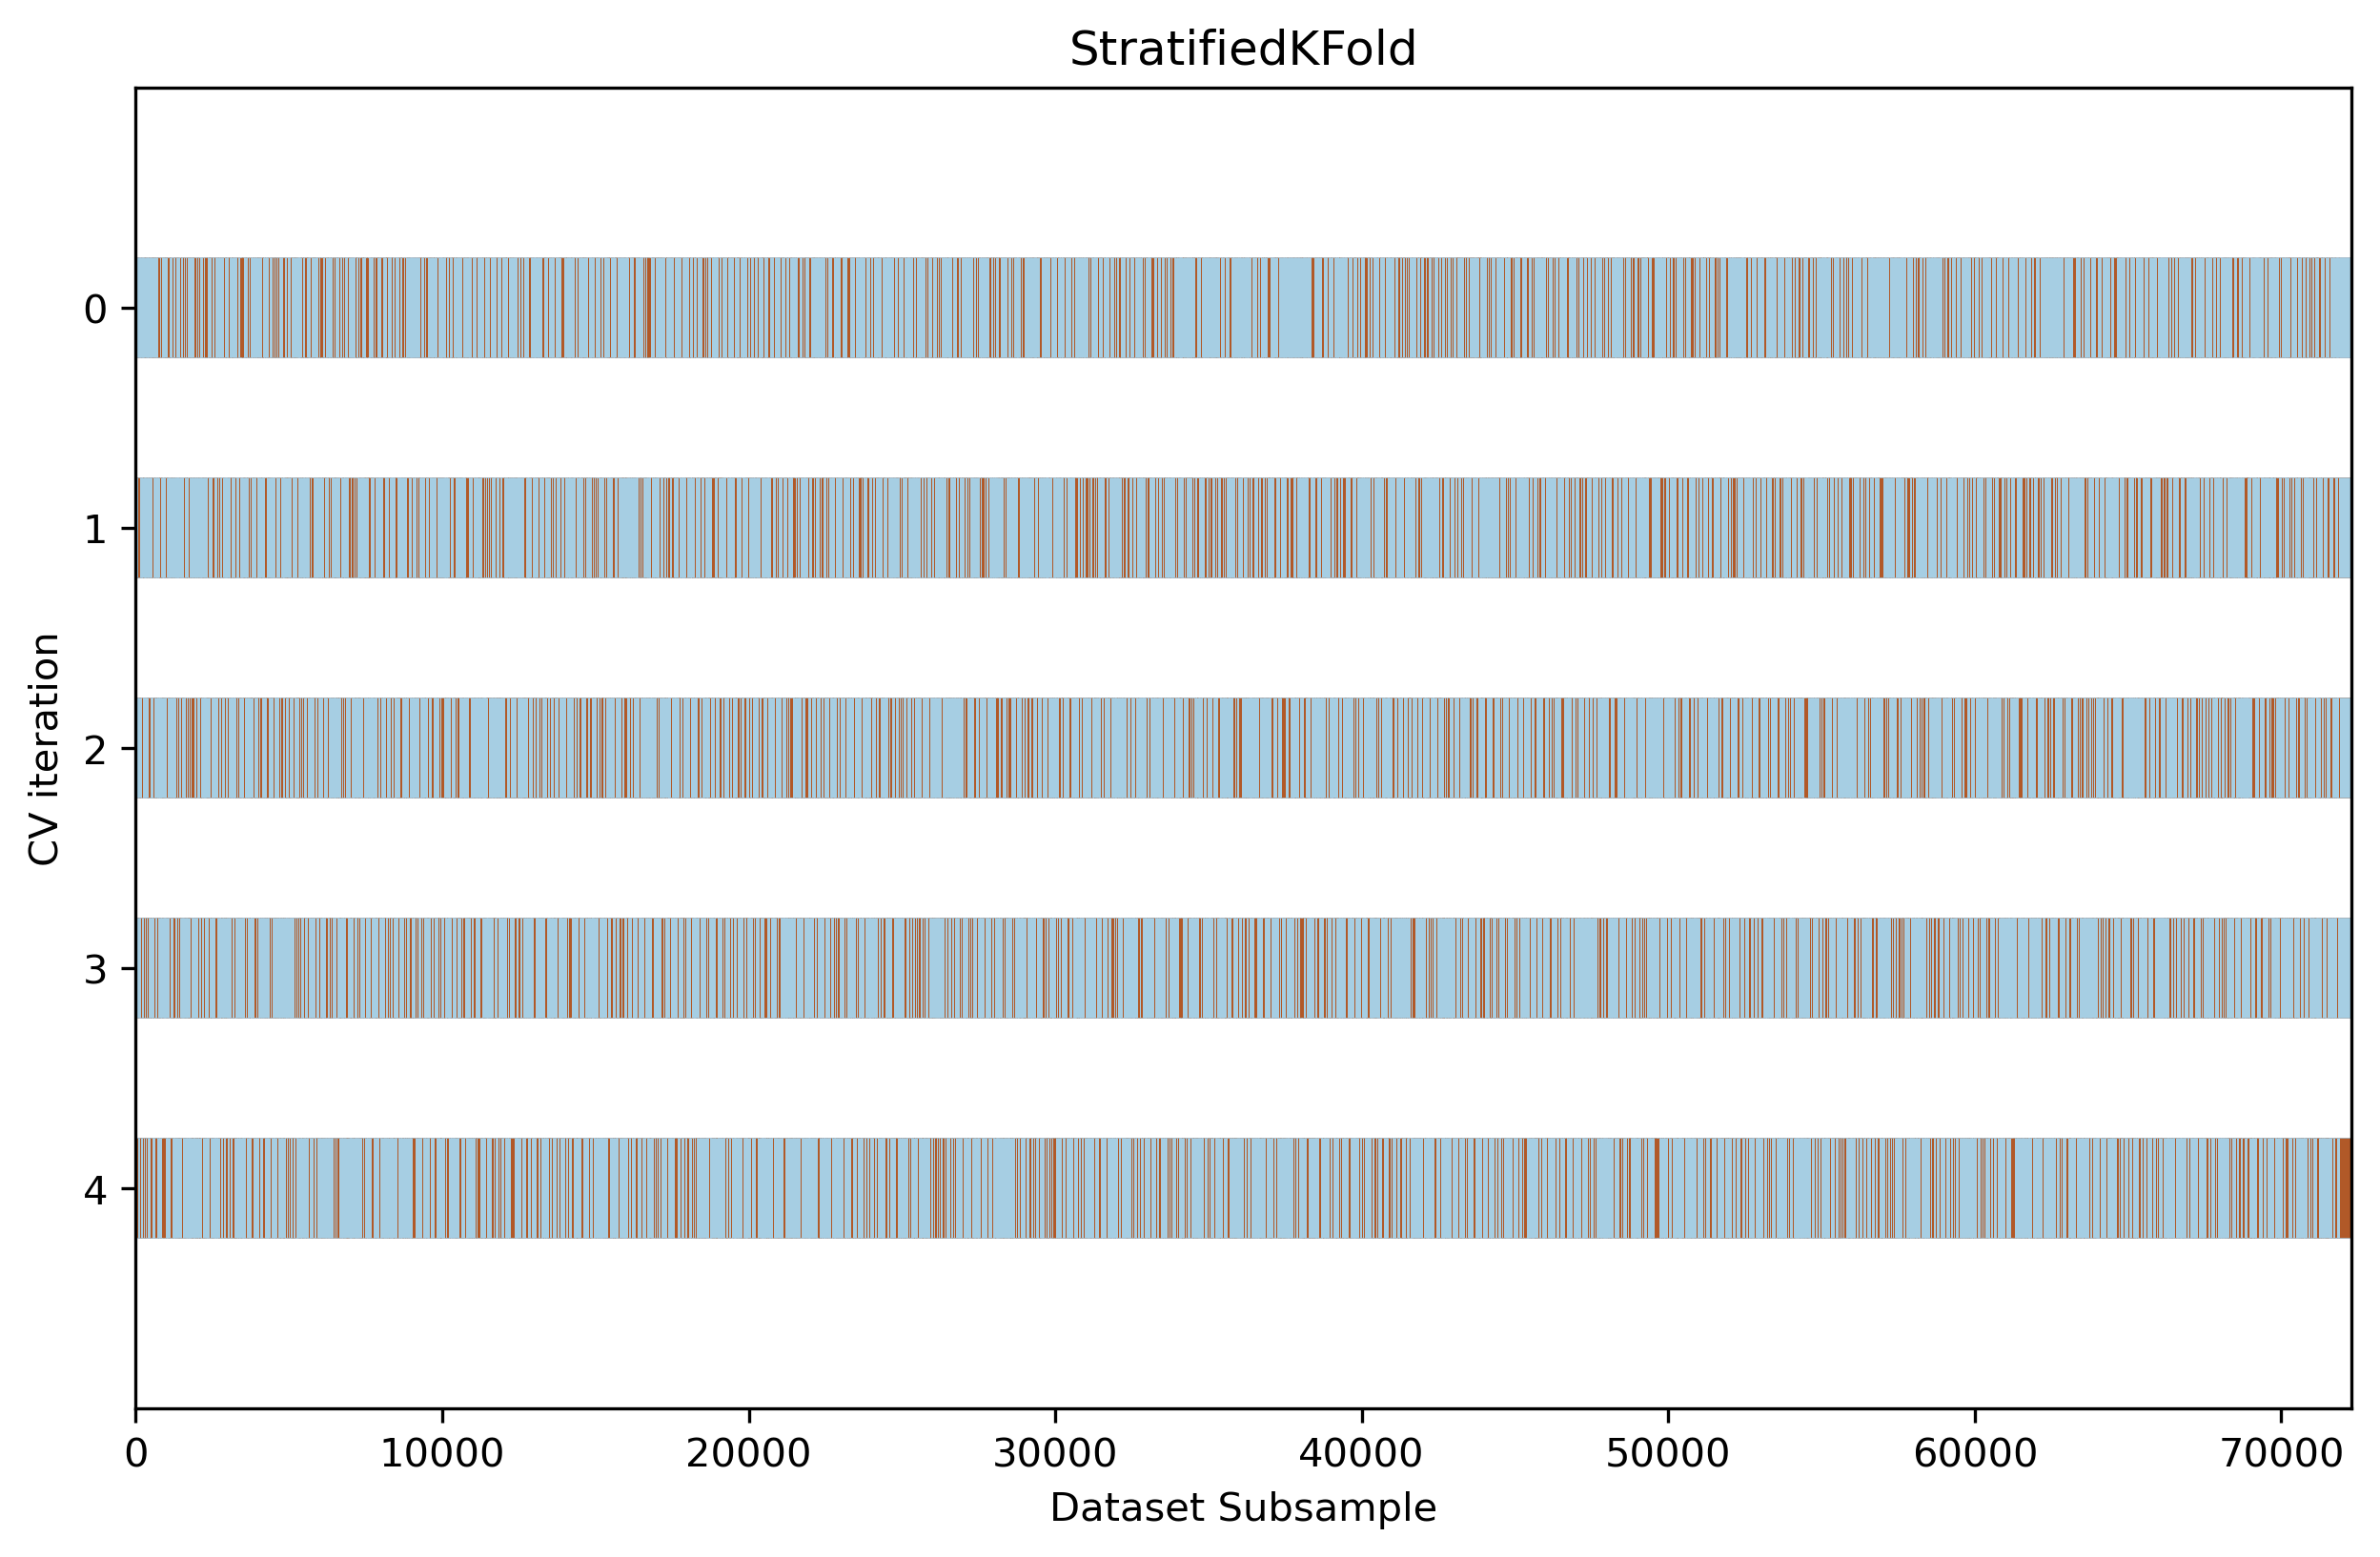

IB/IB_Encoded Dataset


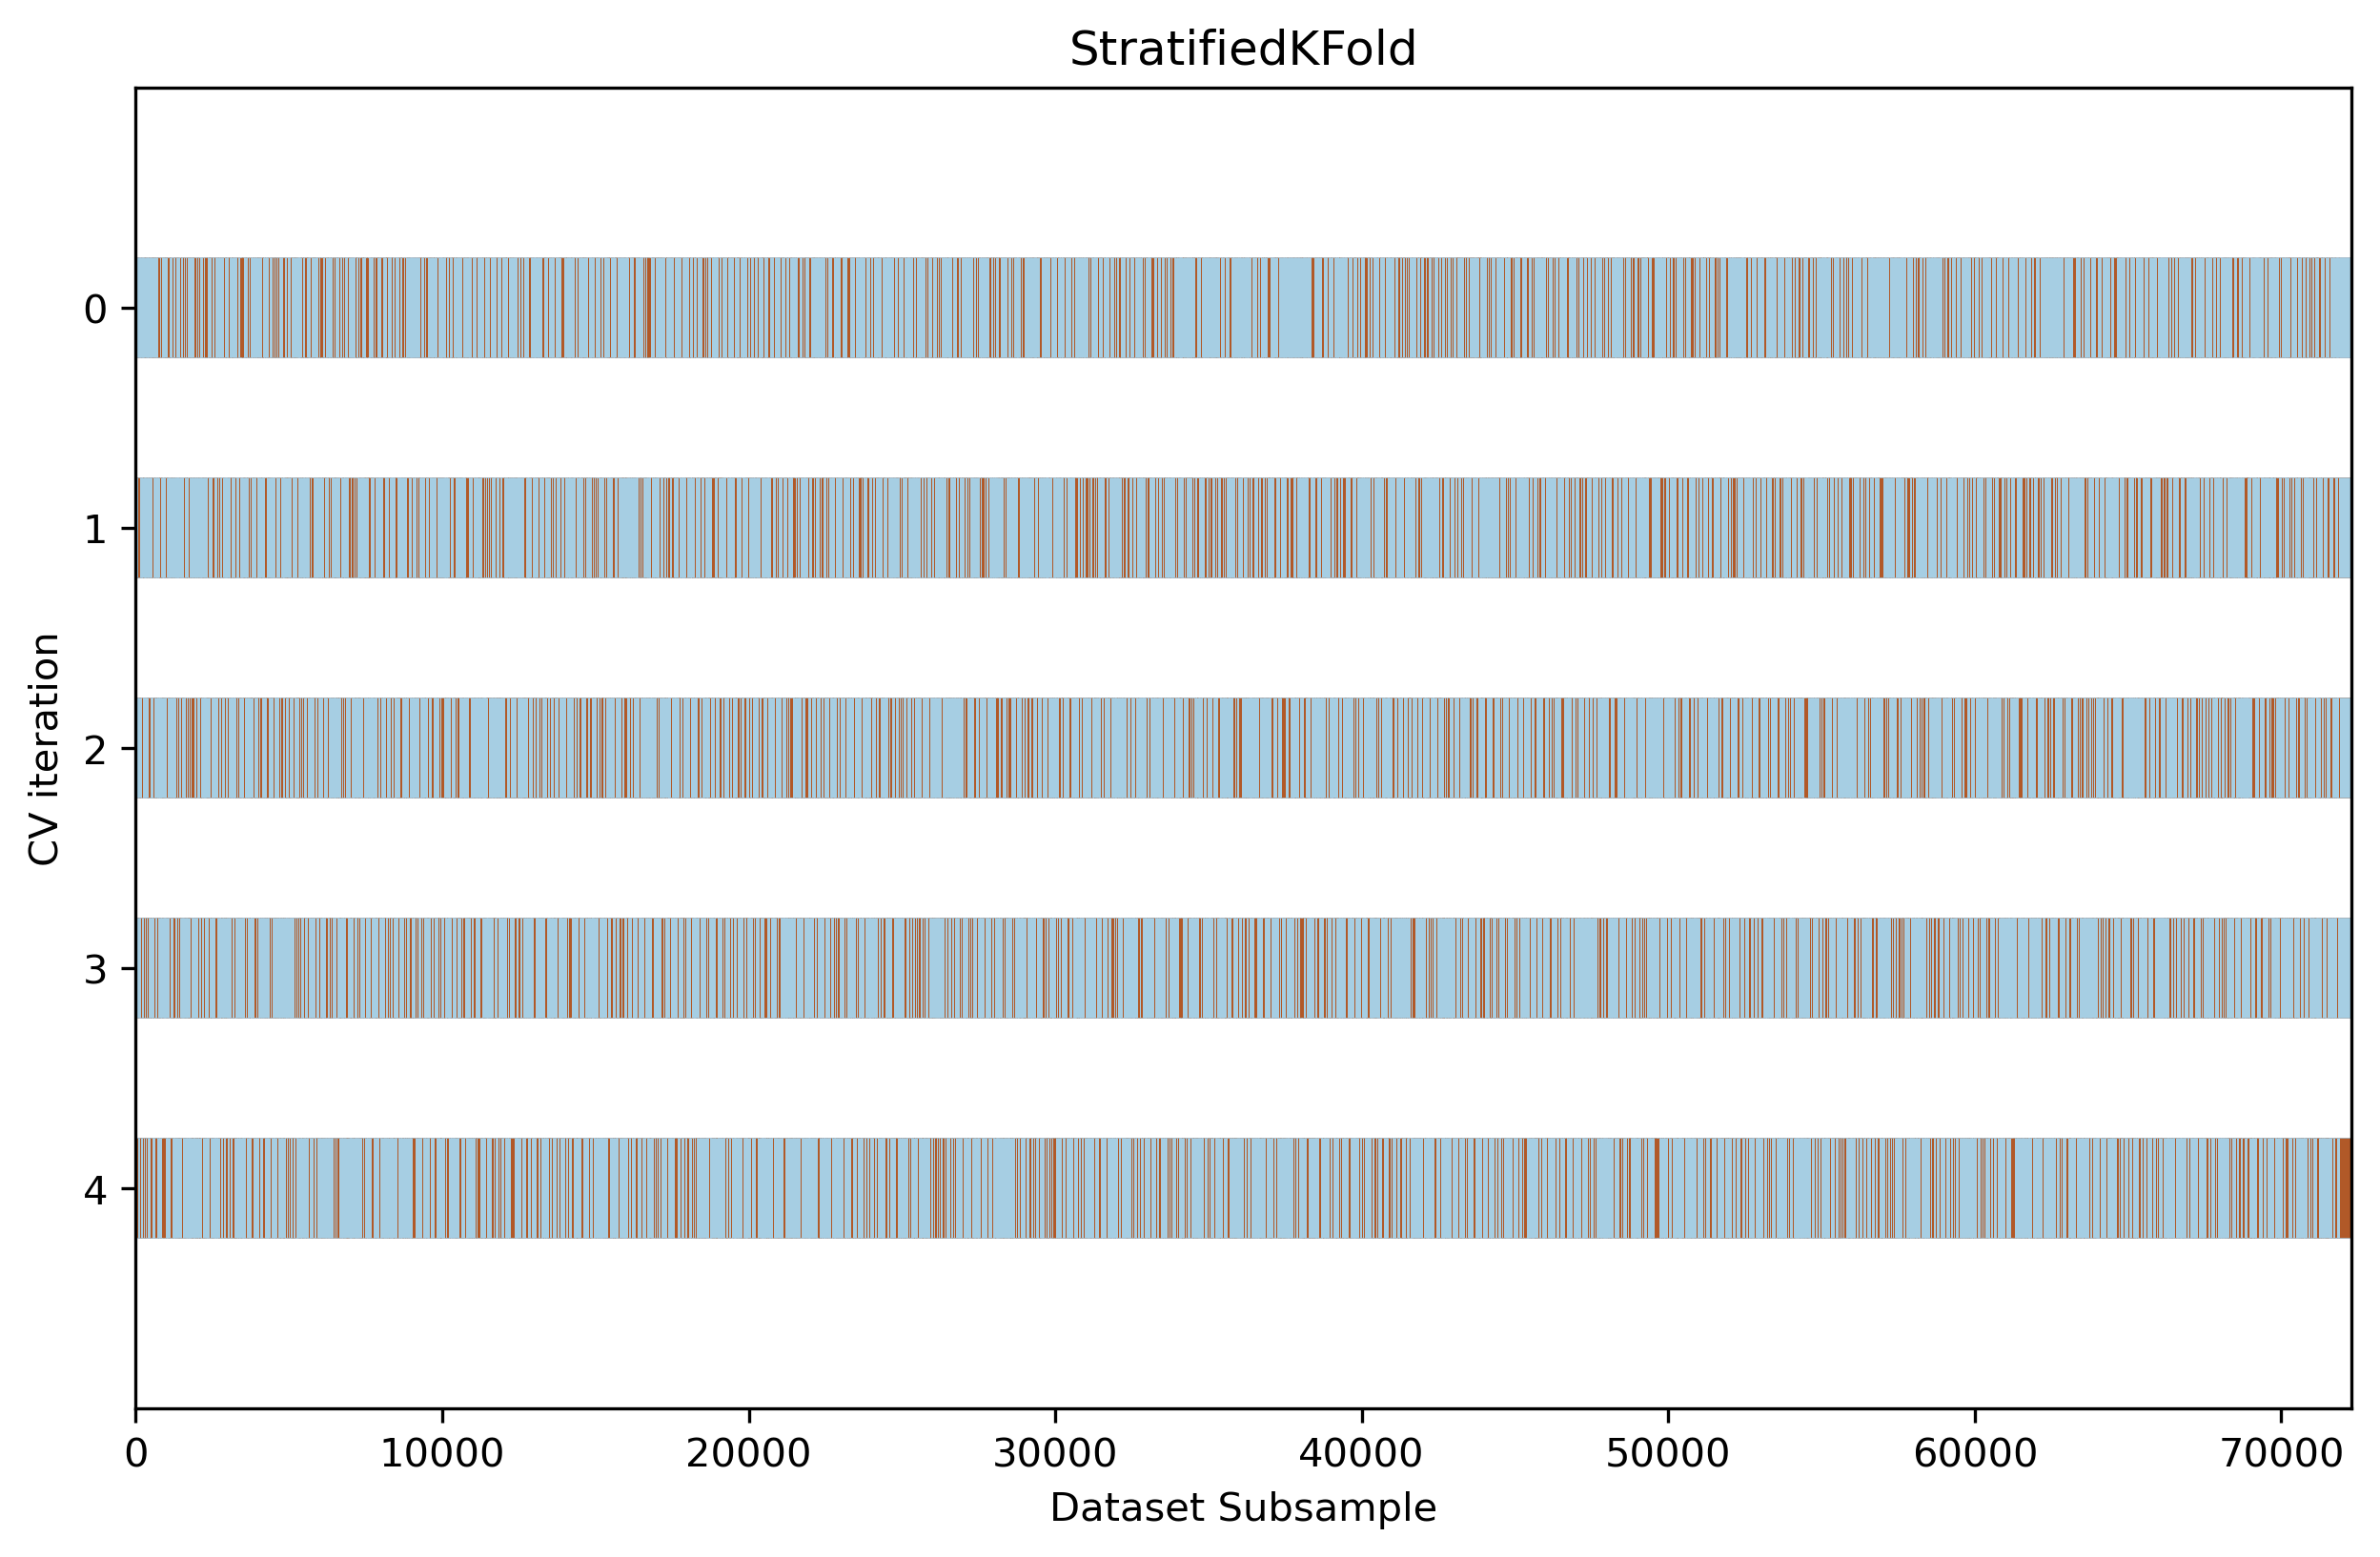

In [10]:
print("Stratified K-Folds Split at",K,"splits.")
print("TB/TB_Encoded Dataset")
kfolds_vis(tb_train)
print("IB/IB_Encoded Dataset")
kfolds_vis(ib_train)

### 1.3.3. Plotting Search CV Results

As suggested from https://stackoverflow.com/a/57013458

In [11]:
def plot_search_results(grid, cv_results, TYPE, scoring=['Accuracy','Precision','Recall','ROC-AUC']):
    ## Results from grid search
    results = grid.cv_results_
    means_test_acc = results['mean_test_accuracy']
    stds_test_acc = results['std_test_accuracy']
    means_test_prec = results['mean_test_precision']
    stds_test_prec = results['std_test_precision']
    means_test_rec = results['mean_test_recall']
    stds_test_rec = results['std_test_recall']
    means_test_auc = results['mean_test_roc_auc']
    stds_test_auc = results['std_test_roc_auc']
    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))
    params = grid.get_params()['param_grid']
    ## Plotting results (per Hyperparam)
    plot_row = 0
    if len(params)%3 == 0:
        plot_row = int(len(params)/3)
    else:
        plot_row = int(len(params)/3) + 1
    fig, ax = plt.subplots(plot_row,3, sharex='none', sharey='none',figsize=(16,4*plot_row), dpi=300, layout='constrained')
    fig.suptitle('Performance on Different Hyperparameter Values (uses Validation Split)')
    pram_preformace_in_best = {}
    row = col = 0
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        ax[row, col].set_ylabel("Mean Score")
        ax[row,col].errorbar(x, np.array(means_test_acc[best_index]), np.array(stds_test_acc[best_index]), linestyle='-', marker='o', label='Accuracy')
        ax[row,col].errorbar(x, np.array(means_test_prec[best_index]), np.array(stds_test_prec[best_index]), linestyle='-', marker='o', label='Precision')
        ax[row,col].errorbar(x, np.array(means_test_rec[best_index]), np.array(stds_test_rec[best_index]), linestyle='-', marker='o', label='Recall')
        ax[row,col].errorbar(x, np.array(means_test_auc[best_index]), np.array(stds_test_auc[best_index]), linestyle='-', marker='o', label='AUC-ROC')
        ax[row,col].legend()
        ax[row,col].set_xlabel(p.upper())
        col += 1
        if col == 3:
            col = 0
            row += 1
    plt.savefig('Outputs/LGBM/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_HYPERPARAMS'+".png")
    plt.show()
    ## Plotting results (per Iteration)
    plt.figure(figsize=(16,9), dpi=600)
    plt.ylabel('Score')
    plt.xlabel('Tuning Iterations')
    plt.plot(cv_results.index, cv_results['mean_test_accuracy'], linestyle='-', marker='o', label='Accuracy')
    # plt.savefig('Outputs/LGBM/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_ACCURACY'+".png")
    plt.plot(cv_results.index, cv_results['mean_test_precision'], linestyle='-', marker='o', label='Precision')
    # plt.savefig('Outputs/LGBM/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_PRECISION'+".png")
    plt.plot(cv_results.index, cv_results['mean_test_recall'], linestyle='-', marker='o', label='Recall')
    # plt.savefig('Outputs/LGBM/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_RECALL'+".png")
    plt.plot(cv_results.index, cv_results['mean_test_roc_auc'], linestyle='-', marker='o', label='AUC-ROC')
    plt.title("Performance on Different Hyperparameter Values (uses Validation Split)")
    plt.savefig('Outputs/LGBM/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_ITERATIONS'+".png")
    plt.legend(loc='upper left')
    plt.show()

In [12]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(i)
    return indexes

## 2. Tuning Proper

*Actual Model Tuning Process*

**Notes:**
1. Not all hyperparameters are compatible with each other.
2. Select, test, and prioritize ones that are relevant to the project.
3. The example shown below are already tested for compatibility. 
4. Watch your terminal for outputs.

LGBM Hyperparameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

CatBoost Hyperparameters: https://catboost.ai/en/docs/references/training-parameters/

## 2.1. Tuning Preparation

The `refit_strategy()` contains the code for model tuning strategy where multiple metrics are considered as part of the model selection process. The order of metrics (by importance) are as follows: Accuracy, Precision, Recall, & Training Time.

In [13]:
#Create the Stratified K-Folds
stratKFold = get_strat_kfold()

#Specify features (X) and labels (y) for Time-based data
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only

#Specify features (X) and labels (y) for Instance-based data
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only

def get_threshold(cv_results, target:str):
    return cv_results[target].max() - (2*cv_results[target].std())

def refit_strategy(cv_results):
    cv_results_ = pd.DataFrame(cv_results)
    # Filter-out all results below 80% score on acc, prec, & recall
    cv_results_ = cv_results_[cv_results_["mean_test_accuracy"] >= .80]
    cv_results_ = cv_results_[cv_results_["mean_test_precision"] >= .80]
    cv_results_ = cv_results_[cv_results_["mean_test_recall"] >= .80]
    cv_results_ = cv_results_[cv_results_["mean_test_f1"] >= .80]
    cv_results_ = cv_results_[cv_results_["mean_test_roc_auc"] >= .80]
    # Filter-out all results below max-std threshold score on acc, prec, & recall
    cv_results_ = cv_results_[cv_results_["mean_test_accuracy"] >= get_threshold(cv_results_, 'mean_test_accuracy')]
    cv_results_ = cv_results_[cv_results_["mean_test_precision"] >= get_threshold(cv_results_, 'mean_test_precision')]
    cv_results_ = cv_results_[cv_results_["mean_test_recall"] >= get_threshold(cv_results_, 'mean_test_recall')]
    cv_results_ = cv_results_[cv_results_["mean_test_f1"] >= get_threshold(cv_results_, 'mean_test_f1')]
    cv_results_ = cv_results_[cv_results_["mean_test_roc_auc"] >= get_threshold(cv_results_, 'mean_test_roc_auc')]
    cv_results_.to_csv(f"./Outputs/LGBM/CVRes_{time.time()}.csv", index=False)
    display(cv_results_)
    return cv_results_['mean_fit_time'].idxmax()

def get_tuner(model, params, scoring=['accuracy','precision','recall', 'roc_auc', 'f1']):
    return GridSearchCV(model, params, scoring=scoring, n_jobs=1, refit=refit_strategy, 
                        cv=get_strat_kfold(), verbose=2, pre_dispatch=8, error_score=0, return_train_score=True)

## 2.3. Instance-based Model Tuning

In [14]:
start_time()
lgbm_classifier = lightgbm.LGBMClassifier(random_state=1, n_jobs=0, verbose=-1)
ib_tuner = get_tuner(lgbm_classifier, lgbm_params)
ib_tuner.fit(X_ib, y_ib, categorical_feature=get_indexes())
end_time("LGBM_IB")

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boostin

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=   8.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=   8.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=   8.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  17.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  17.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  17.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   6.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   6.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   7.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  13.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  14.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  14.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=   9.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=   9.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  10.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  20.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  21.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  20.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   8.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   8.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   8.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  16.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  16.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  16.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   6.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   6.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   6.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  10.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  10.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  12.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  21.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  20.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  21.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, d

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=   8.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=   8.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=   8.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  17.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  18.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  18.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sam

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   6.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   7.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   7.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  12.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  13.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  13.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=   9.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=   9.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=   9.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  18.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  20.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  20.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sam

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   7.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   7.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   8.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  15.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  15.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  15.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=   9.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=   9.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  10.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  20.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  21.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  20.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, d

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   8.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   8.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   8.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  18.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  19.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  18.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   7.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   7.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   7.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  10.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=   9.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  14.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  21.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  20.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  22.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  10.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=   9.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  10.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  21.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  21.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  24.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   7.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   8.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   8.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  14.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  14.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  14.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  22.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  10.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  10.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  10.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  21.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  23.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  22.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=5, class_weight=balanced, d

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_str

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   8.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   8.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   8.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  17.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  17.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  17.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  11.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  11.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  11.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  23.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  23.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  23.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   9.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   9.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=   9.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  18.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  20.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  21.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   8.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   8.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  11.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  11.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  11.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  23.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  24.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  24.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, d

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  11.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  11.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  11.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  22.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  21.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  24.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strateg

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   8.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   8.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   9.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  17.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  17.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  17.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  23.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  13.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  14.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  13.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  24.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  24.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  24.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=   9.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  10.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  10.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  20.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  20.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  20.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  12.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  12.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  12.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  25.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  25.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  26.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, d

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  11.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  11.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  11.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  21.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  24.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  23.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strateg

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  10.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=   9.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  11.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  12.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  11.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  24.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  25.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  24.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  12.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  12.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  12.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  24.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  24.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  25.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_stra

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   3.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   3.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   3.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  10.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  10.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  10.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  20.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  20.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  20.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  26.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  12.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  13.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  13.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  27.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  27.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  27.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, d

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sampl

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   3.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  11.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  11.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  11.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  23.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  23.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  23.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=7, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_str

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  13.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  12.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  12.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  26.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  26.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  26.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  12.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  12.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  12.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  23.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  26.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  26.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   4.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  10.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  10.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  13.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  14.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  13.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  27.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  28.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  27.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   4.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   4.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   4.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  13.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  14.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  14.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, d

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  26.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  26.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  26.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   4.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  11.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  11.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, da

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  14.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  14.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  14.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  29.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  28.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.1, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  29.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balance

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   4.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   4.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   4.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  13.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  13.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  13.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sam

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  30.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  25.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  27.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=10, num_leaves=4, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   3.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  12.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  11.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  11.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  14.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  21.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  23.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  28.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  26.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  29.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=100, num_leaves=16, objective=binary, tree_learner=feature; total time=   4.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   4.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   4.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  16.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  16.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  16.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  29.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  29.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  28.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sam

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   3.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   3.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   3.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  12.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  13.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  12.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  24.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  23.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  24.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  30.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=feature; total time=  29.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, d

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=10, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   4.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   4.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   4.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  14.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  14.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=500, num_leaves=16, objective=binary, tree_learner=feature; total time=  14.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=feature; total time=  29.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  29.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.2, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  30.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=5, num_leaves=8, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_str

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=50, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   4.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   4.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=100, num_leaves=4, objective=binary, tree_learner=feature; total time=   4.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=2, objective=binary, tree_learner=feature; total time=  12.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  13.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  13.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  25.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  23.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=5, n_estimators=1000, num_leaves=2, objective=binary, tree_learner=feature; total time=  24.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=5, num_leaves=64, objective=binary, tree_learner=feature; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=10, num_leaves=64, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=50, num_leaves=32, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   4.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   4.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=100, num_leaves=32, objective=binary, tree_learner=feature; total time=   4.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  15.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  15.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  15.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  30.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=feature; total time=  27.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=10, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  30.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=10, num_leaves=8, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sa

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   4.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   4.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   4.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  14.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  14.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  14.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  25.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  27.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=50, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  25.6s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=5, num_leaves=4, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_samp

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=10, num_leaves=2, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=2, objective=binary, tree_learner=feature; total time=   3.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=feature; total time=   3.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=2, objective=binary, tree_learner=feature; total time=   4.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   4.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   4.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=feature; total time=   4.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  17.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=500, num_leaves=32, objective=binary, tree_learner=feature; total time=  16.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=500, num_leaves=64, objective=binary, tree_learner=feature; total time=  16.0s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  31.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  31.9s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=100, n_estimators=1000, num_leaves=32, objective=binary, tree_learner=feature; total time=  31.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balance

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=5, num_leaves=32, objective=binary, tree_learner=feature; total time=   2.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_s

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=10, num_leaves=16, objective=binary, tree_learner=feature; total time=   2.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=50, num_leaves=8, objective=binary, tree_learner=feature; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=50, num_leaves=16, objective=binary, tree_learner=feature; total time=   3.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   4.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   4.8s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=100, num_leaves=8, objective=binary, tree_learner=feature; total time=   4.7s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=500, num_leaves=4, objective=binary, tree_learner=feature; total time=  14.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  14.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=500, num_leaves=8, objective=binary, tree_learner=feature; total time=  15.4s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, dat

[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  26.3s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  29.1s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, data_sample_strategy=goss, device=gpu, enable_bundle=True, gpu_use_dp=False, learning_rate=0.3, max_bin=255, max_depth=500, n_estimators=1000, num_leaves=4, objective=binary, tree_learner=feature; total time=  26.5s
[CV] END boost_from_average=True, boosting_type=gbdt, cat_l2=10, class_weight=balanced, 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15         1.489998      0.057668         0.092600        0.006021   
16         1.543602      0.106070         0.088799        0.002926   
17         1.371999      0.061601         0.086999        0.006633   
19         1.824601      0.062083         0.093599        0.006711   
20         1.880086      0.083476         0.094773        0.001497   
...             ...           ...              ...             ...   
1603       4.446566      0.138239         0.201796        0.007744   
1604       4.591423      0.051104         0.213701        0.008718   
1605       4.827003      0.033611         0.222081        0.006159   
1606       4.854773      0.076491         0.222287        0.007081   
1607       4.954557      0.033529         0.219765        0.009978   

     param_boost_from_average param_boosting_type param_cat_l2  \
15                       True                gbdt            5   
16                       True                gbdt            5   
17                       True                gbdt            5   
19                       True                gbdt            5   
20                       True                gbdt            5   
...                       ...                 ...          ...   
1603                     True                gbdt           10   
1604                     True                gbdt           10   
1605                     True                gbdt           10   
1606                     True                gbdt           10   
1607                     True                gbdt           10   

     param_class_weight param_data_sample_strategy param_device  ...  \
15             balanced                       goss          gpu  ...   
16             balanced                       goss          gpu  ...   
17             balanced                       goss          gpu  ...   
19             balanced                       goss          gpu  ...   
20             balanced                       goss          gpu  ...   
...                 ...                        ...          ...  ...   
1603           balanced                       goss          gpu  ...   
1604           balanced                       goss          gpu  ...   
1605           balanced                       goss          gpu  ...   
1606           balanced                       goss          gpu  ...   
1607           balanced                       goss          gpu  ...   

     mean_test_f1 std_test_f1 rank_test_f1 split0_train_f1 split1_train_f1  \
15       0.994396    0.000833          852        0.996054        0.996054   
16       0.994492    0.000885          818        0.996329        0.996192   
17       0.994424    0.000801          829        0.996329        0.996192   
19       0.993998    0.000761          957        0.996415        0.996226   
20       0.994779    0.000837          725        0.998463        0.998308   
...           ...         ...          ...             ...             ...   
1603     0.994598    0.000765          753        0.998877        0.998946   
1604     0.995026    0.000847          532        0.999309        0.999274   
1605     0.995206    0.000786          326        0.999326        0.999274   
1606     0.995068    0.000763          462        0.999343        0.999309   
1607     0.995068    0.000763          462        0.999343        0.999309   

     split2_train_f1 split3_train_f1 split4_train_f1 mean_train_f1  \
15          0.996330        0.996243        0.996278      0.996192   
16          0.996535        0.996381        0.996329      0.996353   
17          0.996535        0.996243        0.996329      0.996326   
19          0.996449        0.996088        0.996415      0.996319   
20          0.998584        0.998480        0.998549      0.998477   
...              ...             ...             ...           ...   
1603        0.998963        0.998877        0.998929      0.998919   
1604      

63504.087217

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.600400      0.084360         0.060000        0.002000   
1          0.601199      0.079987         0.061800        0.001165   
2          0.557001      0.009467         0.062199        0.003653   
3          0.582400      0.031218         0.062600        0.001498   
4          0.561600      0.019438         0.066204        0.004073   
...             ...           ...              ...             ...   
1615      27.297469      1.138450         0.568198        0.005672   
1616      29.564455      1.662634         0.735002        0.007237   
1617      31.317593      0.241020         0.768599        0.019168   
1618      30.091568      1.496012         0.755401        0.011569   
1619      30.039295      1.226841         0.791800        0.070573   

     param_boost_from_average param_boosting_type param_cat_l2  \
0                        True                gbdt            5   
1                        True                gbdt            5   
2                        True                gbdt            5   
3                        True                gbdt            5   
4                        True                gbdt            5   
...                       ...                 ...          ...   
1615                     True                gbdt           10   
1616                     True                gbdt           10   
1617                     True                gbdt           10   
1618                     True                gbdt           10   
1619                     True                gbdt           10   

     param_class_weight param_data_sample_strategy param_device  ...  \
0              balanced                       goss          gpu  ...   
1              balanced                       goss          gpu  ...   
2              balanced                       goss          gpu  ...   
3              balanced                       goss          gpu  ...   
4              balanced                       goss          gpu  ...   
...                 ...                        ...          ...  ...   
1615           balanced                       goss          gpu  ...   
1616           balanced                       goss          gpu  ...   
1617           balanced                       goss          gpu  ...   
1618           balanced                       goss          gpu  ...   
1619           balanced                       goss          gpu  ...   

     mean_test_f1 std_test_f1 rank_test_f1 split0_train_f1 split1_train_f1  \
0        0.938428    0.002443         1606        0.938085        0.938581   
1        0.989468    0.000641         1501        0.989543        0.989101   
2        0.991224    0.001338         1411        0.991835        0.991020   
3        0.991477    0.001488         1366        0.991938        0.991917   
4        0.991477    0.001488         1366        0.991938        0.991917   
...           ...         ...          ...             ...             ...   
1615     0.994873    0.000735          694        0.999343        0.999326   
1616     0.995232    0.000682          319        0.999343        0.999326   
1617     0.995355    0.000723          137        0.999343        0.999326   
1618     0.995384    0.000687           73        0.999343        0.999326   
1619     0.995370    0.000700           93        0.999343        0.999326   

     split2_train_f1 split3_train_f1 split4_train_f1 mean_train_f1  \
0           0.938571        0.937911        0.938799      0.938389   
1           0.989491        0.989254        0.989950      0.989468   
2           0.992127        0.991578        0.990682      0.991448   
3           0.992160        0.991406        0.991013      0.991687   
4           0.992160        0.991406        0.991013      0.991687   
...              ...             ...             ...           ...   
1615        0.999361        0.999292        0.999361      0.999336   
1616      

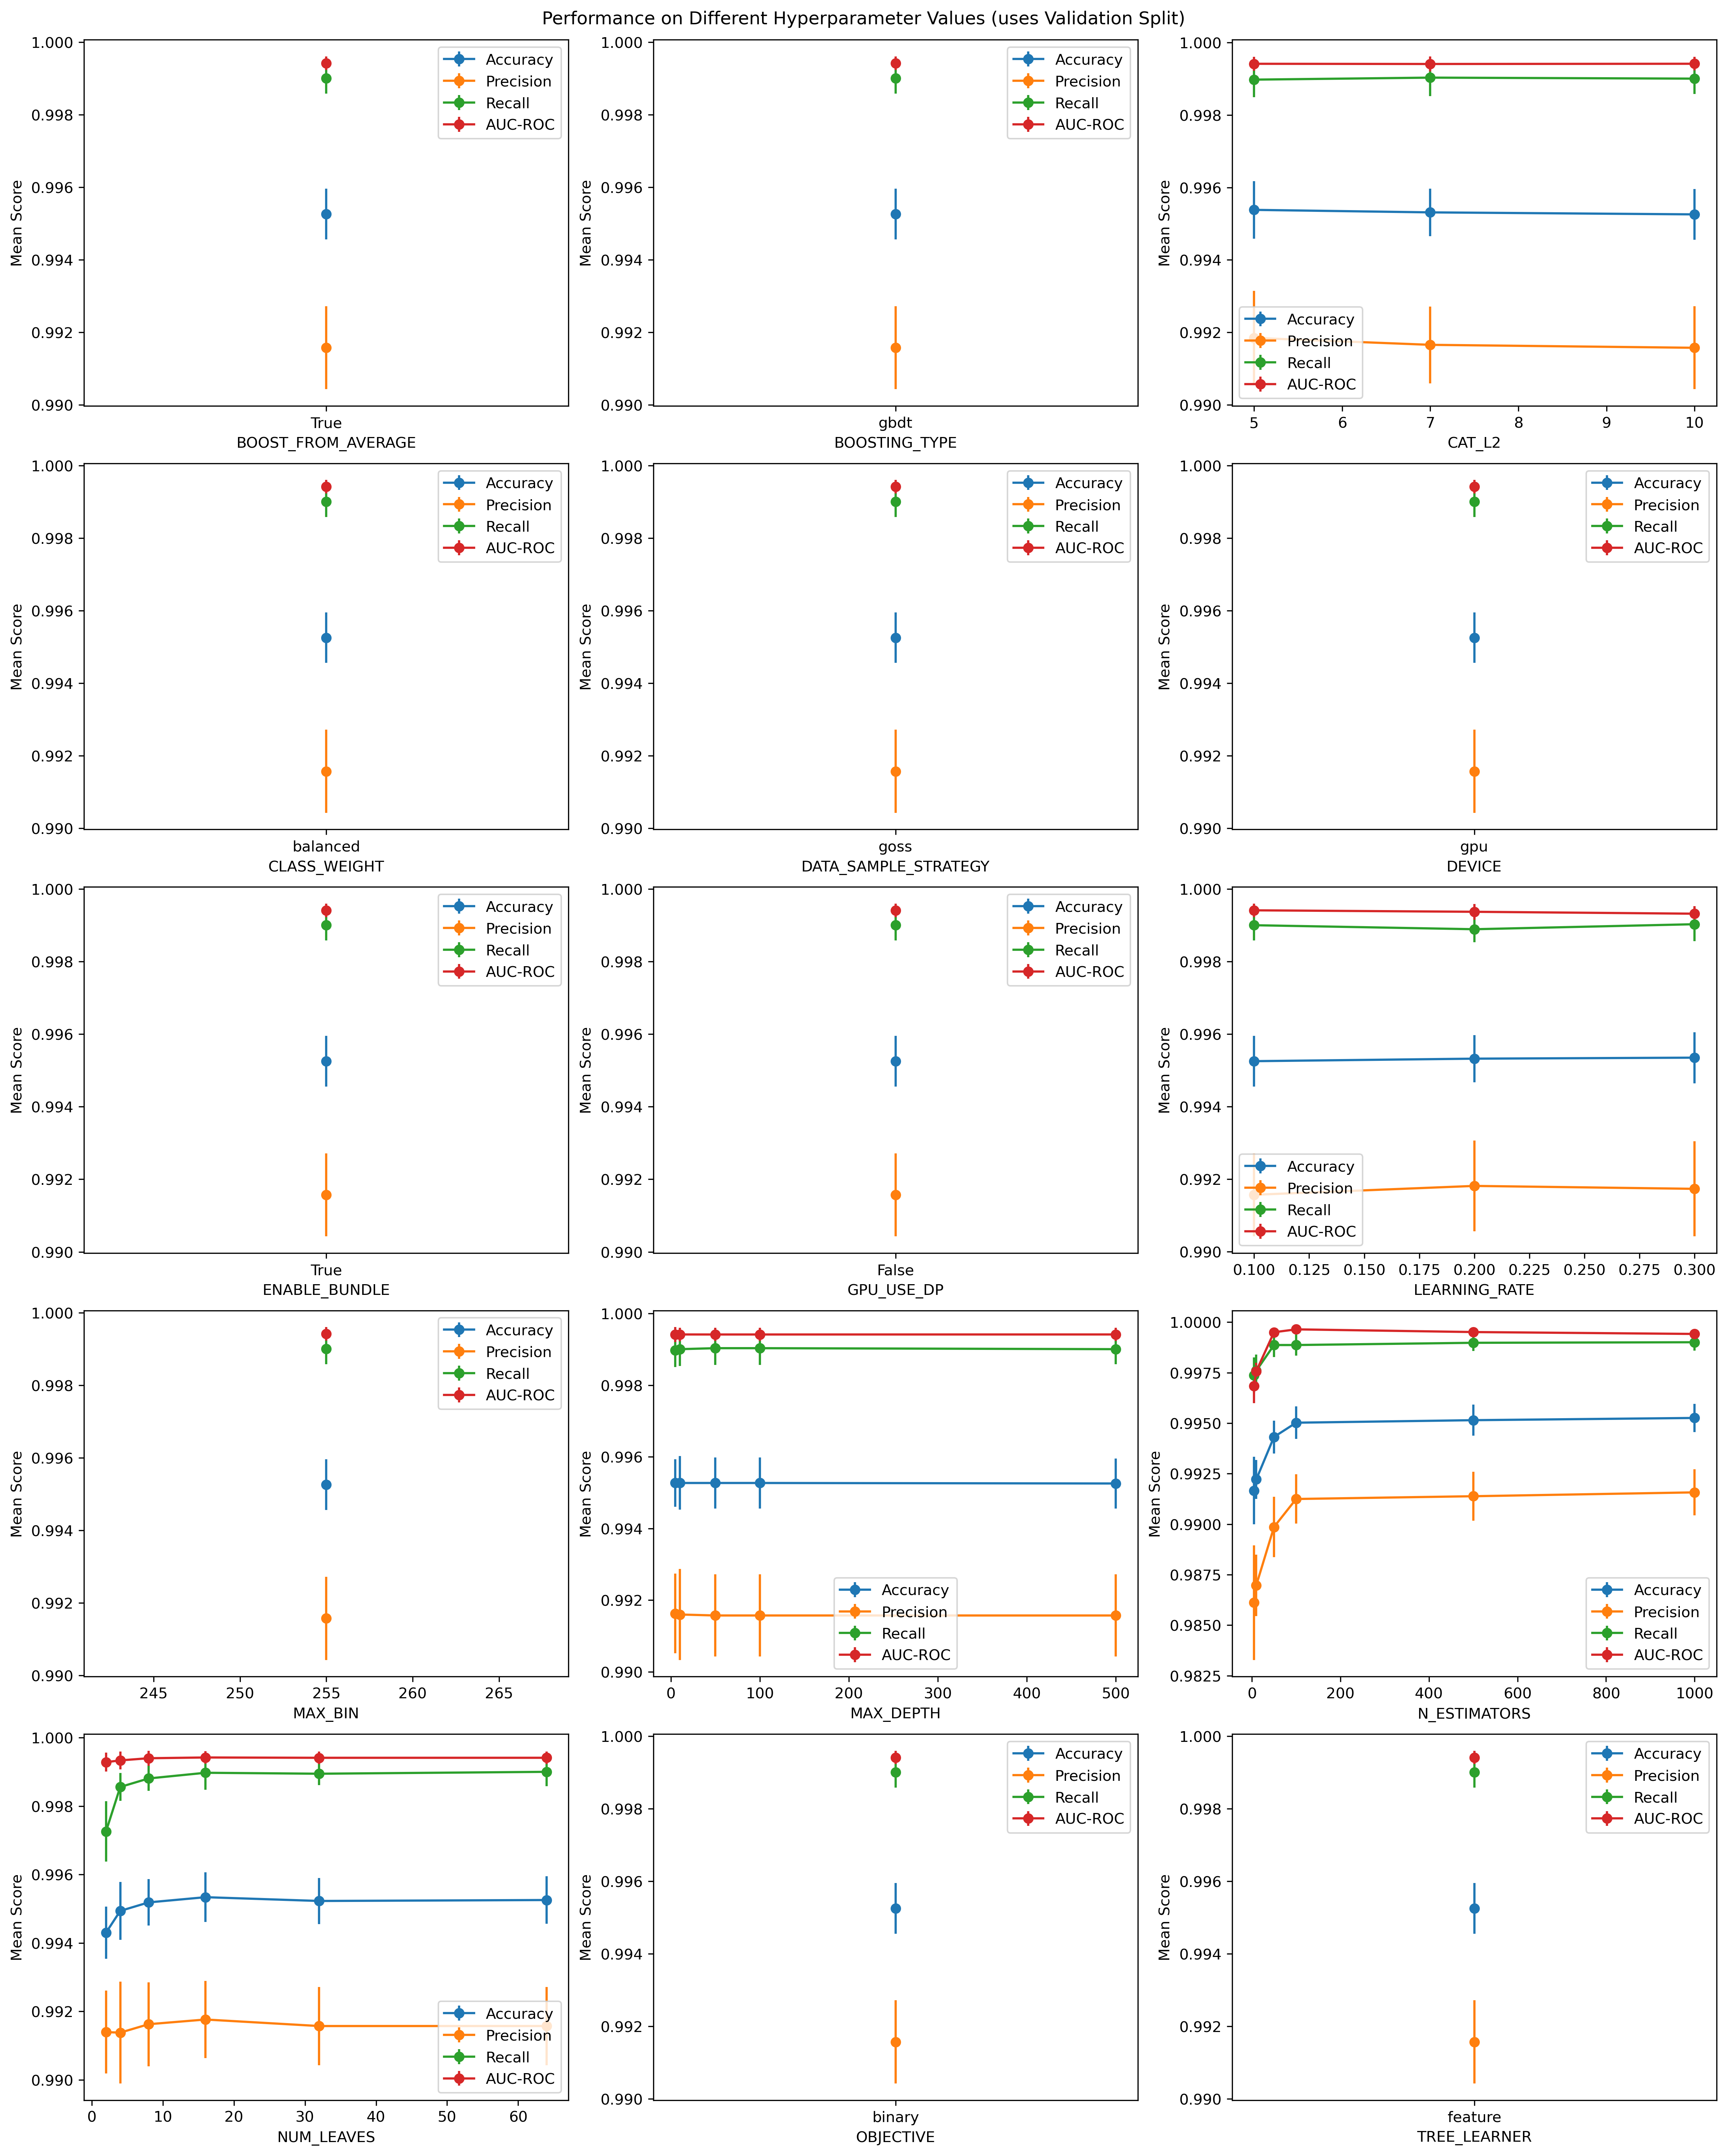

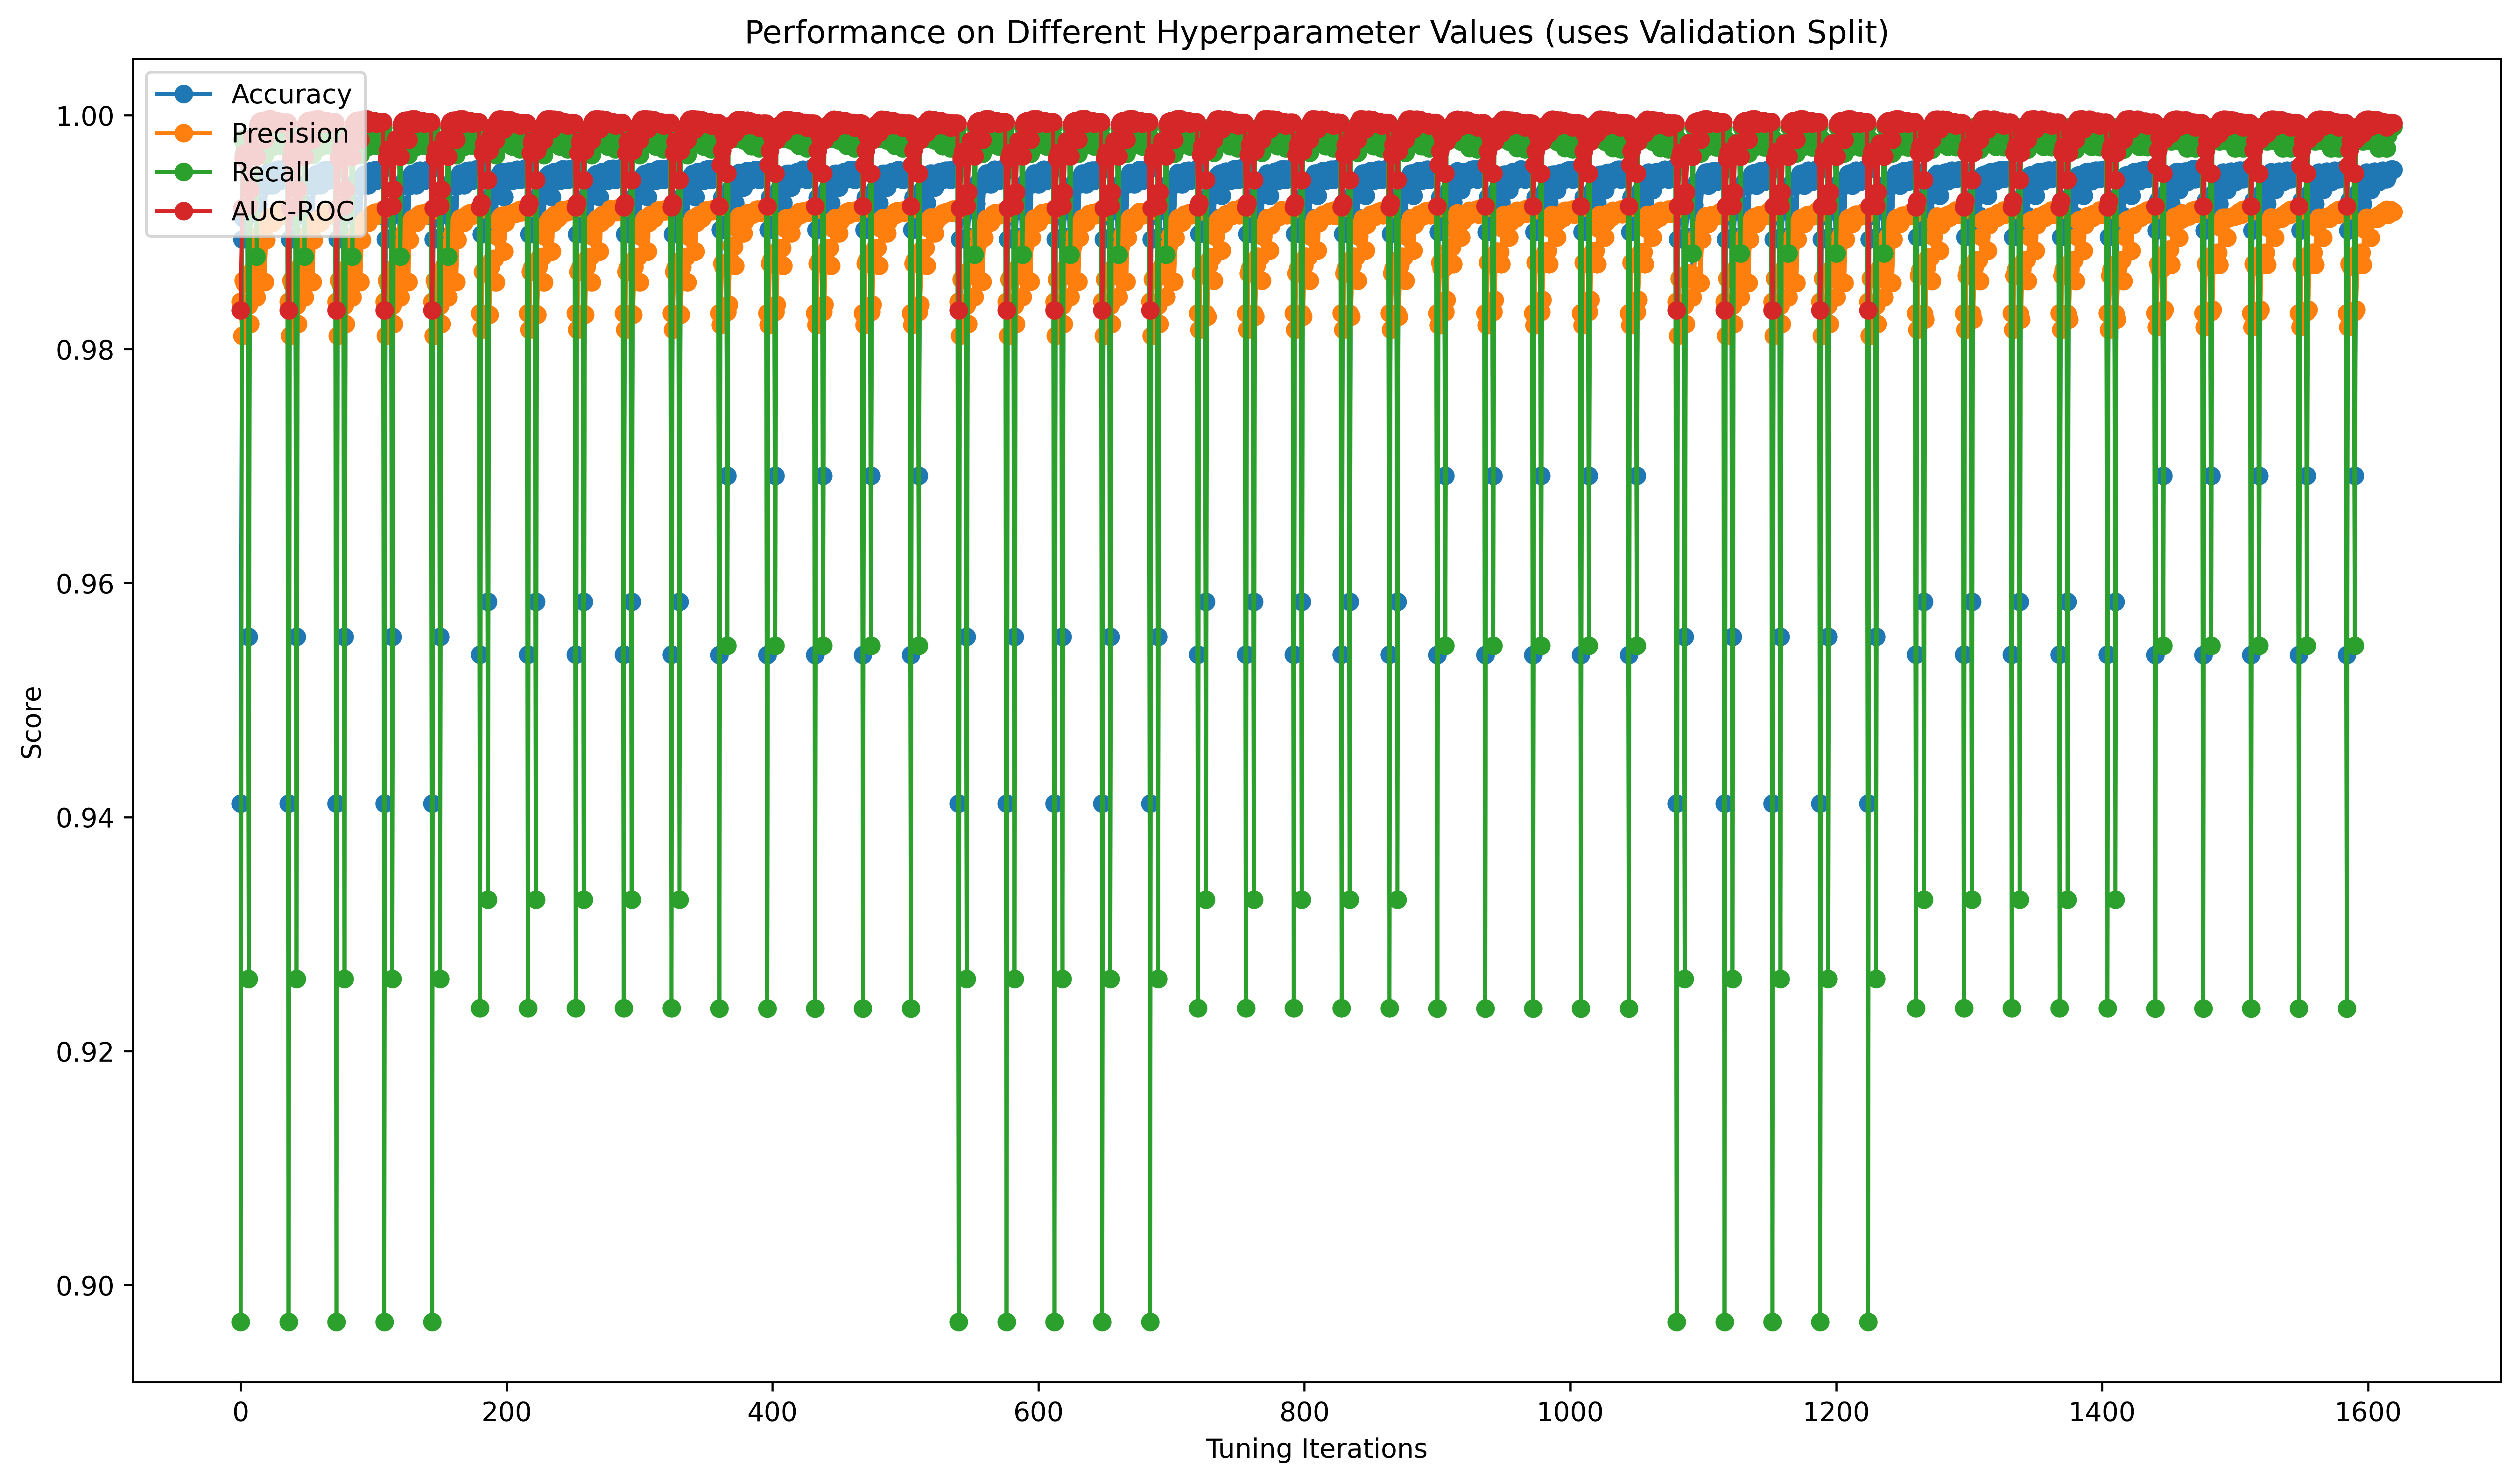

In [15]:
print_to_file("LGBM_IB", ib_tuner.best_params_)
cv_results = pd.DataFrame.from_dict(ib_tuner.cv_results_)
cv_results.to_csv(f"./Outputs/LGBM/{OUTPUT_FILENAME}_LGBM_IB_Tune_CVRes.csv")
display(cv_results)
plot_search_results(ib_tuner, cv_results, 'IB')

In [16]:
logging("\n")